Uses `v2` dataset.

In [ ]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import datetime
import sys
from os import path, environ
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from tqdm.auto import tqdm, trange
from bdx import get_trend

from utils import contiguous_sequences
from plotting import model_surface, plot_surface
from systems import Condenser
from baseline_control import SimpleFeedbackController

chiller_file_1 = path.join(environ['DATADIR'],
                         'EngineeringScienceBuilding',
                         '2422_ESB_HVAC_1.csv')
chiller_file_2 = path.join(environ['DATADIR'],
                         'EngineeringScienceBuilding',
                         '2841_ESB_HVAC_2.csv')

plot_path = path.join('..', 'docs', 'img')
bin_path = './bin/'

In [ ]:
# Choosing which chiller to use
chiller_file = chiller_file_2
# Data selection 'all' or 'chiller_on' or 'fan_on'
MODE = 'chiller_on'
# Read pre-processed data:
# Pytorch uses float32 as default type for weights etc,
# so input data points are also read in the same type.
df = pd.read_csv(chiller_file, index_col='time',
                 parse_dates=['time'], dtype=np.float32)
print('Original length: {} Records'.format(len(df)))
# # These fields were not populated until 2020-07-01, so leaving then out of analysis
# df.drop(['PowFanA', 'PowFanB', 'FlowCond', 'PowChiP', 'PerFreqConP', 'PowConP'], axis='columns', inplace=True)
df.drop(['FlowCond', 'PowChiP', 'PerFreqConP'], axis='columns', inplace=True)

df.dropna(inplace=True)
if MODE == 'chiller_on':
    df = df[df['RunChi'] != 0]
if MODE == 'fan_on':
    df = df[(df['RunFanA'] != 0.) | df['RunFanB'] != 0.]
print('Processed length: {} Records'.format(len(df)))

In [ ]:
df.describe()

## Condenser model

State variables (12):

`'TempCondIn', 'TempCondOut', 'TempEvapOut', 'PowChi', 'PowFanA', 'PowFanB', 'PowConP', 'TempEvapIn', 'TempAmbient', 'TempWetBulb', 'PressDiffEvap', 'PressDiffCond'`

Action variables (1):

`'TempCondInSetpoint'`

Output variables (3):

`'TempCondIn', 'TempCondOut', 'TempEvapOut', 'PowChi', 'PowFanA', 'PowFanB', 'PowConP'`

Model:

`[Action, State] --> [Output]`

In [ ]:
actionvars = ['TempCondInSetpoint']
statevars = ['TempCondIn', 'TempCondOut', 'TempEvapOut',
             'PowChi', 'PowFanA', 'PowFanB', 'PowConP',
             'TempEvapIn', 'TempAmbient', 'TempWetBulb', 'PressDiffEvap', 'PressDiffCond']
inputs =  actionvars + statevars 
outputs = ['TempCondIn', 'TempCondOut', 'TempEvapOut',
           'PowChi', 'PowFanA', 'PowFanB', 'PowConP']
lag = (1, 1, 1, 1, 1, 1, 1)    # 0, 1, 2, 3, 4, ...

df_in = pd.DataFrame(columns=inputs, index=df.index)
df_in['TempCondInSetpoint'] = np.clip(df['TempWetBulb'] - 4, a_min=65, a_max=None)  # approach controller
df_in[inputs[1:]] = df[inputs[1:]]

df_out = pd.DataFrame(columns=outputs, index=df.index)
df_out[outputs] = df[outputs]

idx_list = contiguous_sequences(df.index, pd.Timedelta(5, unit='min'), filter_min=10)

# Create dataframes of contiguous sequences with a delay
# of 1 time unit to indicate causality input -> outputs
dfs_in, dfs_out = [], []
for idx in idx_list:
    dfs_in.append(df_in.loc[idx[:-max(lag) if max(lag) > 0 else None]])
    cols = []
    for l, c in zip(lag, outputs):
        window = slice(l, None if l==max(lag) else -(max(lag)-l))
        series = df_out[c].loc[idx[window]]
        cols.append(series.values)
        if l == min(lag): index = series.index
    dfs_out.append(pd.DataFrame(np.asarray(cols).T, index=index, columns=outputs))

df_in = pd.concat(dfs_in, sort=False)
df_out = pd.concat(dfs_out, sort=False)

print('{:6d} time series'.format(len(dfs_in)))
print('{:6d} total rows'.format(len(df_in)))

In [ ]:
std_in_cond, std_out_cond = StandardScaler(), StandardScaler()
net = MLPRegressor(hidden_layer_sizes=(64, 64, 32),
                   activation='relu',
                   solver='adam',
                   verbose=True,
                   early_stopping=True,
                   learning_rate_init=1e-4)
est_cond = Pipeline([('std', std_in_cond), ('net', net)])

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=FutureWarning)
    est_cond.fit(df_in, std_out_cond.fit_transform(df_out))

In [ ]:
# Save model
save = {
    'loss': est_cond['net'].loss_,
    'estimator': est_cond,
    'input_norm': std_in_cond,
    'output_norm': std_out_cond,
    'actionvars': actionvars,
    'statevars': statevars,
    'inputs': inputs,
    'outputs': outputs,
    'lag': lag,
}
with open(path.join(bin_path, 'v2_condenser'), 'wb') as f:
    pickle.dump(save, f)

In [ ]:
# load model
with open(path.join(bin_path, 'v2_condenser'), 'rb') as f:
    save = pickle.load(f, fix_imports=False)
    est_cond = save['estimator']
    std_out_cond = save['output_norm']

In [ ]:
# Visualize model predictions
test_in, test_out = dfs_in[2], dfs_out[2]
pred = pd.DataFrame(std_out_cond.inverse_transform(est_cond.predict(test_in)),
                    index=test_out.index, columns=test_out.columns)

plt.subplot(4, 1, 1)
test_in.loc[:, ('TempCondIn')].plot(grid=True, style='g:', label='TempCondIn')
test_out.loc[:, ('TempCondIn')].plot(grid=True, style='-', label='TempCondIn-Next')
pred.loc[:, ('TempCondIn')].plot(grid=True, style='-', label='TempCondIn-Next-Pred')
plt.legend()
plt.subplot(4, 1, 2)
test_in.loc[:, ('TempCondOut')].plot(grid=True, style='g:', label='TempCondOut')
test_out.loc[:, ('TempCondOut')].plot(grid=True, style='-', label='TempCondOut-Next')
pred.loc[:, ('TempCondOut')].plot(grid=True, style='-', label='TempCondOut-Next-Pred')
plt.legend()
plt.subplot(4, 1, 3)
test_out.loc[:, ('PowChi')].plot(grid=True, label='PowChi')
pred.loc[:, ('PowChi')].plot(grid=True, label='PowChi-Pred')
plt.legend()
plt.subplot(4, 1, 4)
test_out.loc[:, ('PowFanA')].plot(grid=True, label='PowFanA')
pred.loc[:, ('PowFanA')].plot(grid=True, label='PowFanA-Pred')
plt.legend()

In [ ]:
point = df_in.loc['2020-07-10T1200-6'].values.reshape(1, -1)
x, y, z = model_surface(lambda x: std_out_cond.inverse_transform(est_cond.predict(x))[:,2],
                        X=point, vary_idx=(0, 3),vary_range=((65, 85), (75, 95)), vary_num=(20, 20))
ax = plot_surface(x,y,z, cmap=plt.cm.coolwarm)
ax.set_xlabel('TempCondInSetpoint')
ax.set_ylabel('TempAmbient')
ax.set_zlabel('TempCondIn-Next Cycle')

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal

class Est(nn.Module):
    
    def __init__(self, inputs, outputs, epochs=50, lr=1e-3):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs
        self.epochs = epochs
        self.lr = lr
        self.net = nn.Sequential(
            nn.Linear(inputs, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 32), nn.Tanh(),
            nn.Linear(32, outputs + outputs), nn.Tanh(),
        )

    def forward(self, X):
        X = torch.as_tensor(X)
        pred = self.net(X)
        mu, var = pred[...,:self.outputs], pred[...,self.outputs:]
        y = torch.zeros(len(X), self.outputs)
        p_y = torch.zeros(len(X))
        entropy = torch.zeros(len(X))
        for i in range(len(X)):
            covmat = torch.diag(torch.abs(var[i]))
            dist = MultivariateNormal(mu[i], covmat)
            y[i] = dist.sample()
            p_y[i] = dist.log_prob(y[i])
            entropy[i] = dist.entropy().sum()
        return y, p_y, entropy

    def fit(self, X, y):
        losses = []
        opt = optim.Adam(self.net.parameters(), lr=self.lr)
        for i in trange(self.epochs):
            opt.zero_grad()
            y_pred, p_y, entropy = self.forward(X)
            pred_loss = torch.mean((y_pred - y)**2, 1)
            weighed_pred_loss = torch.mean(torch.exp(p_y) * pred_loss)
            loss = (-0.1* entropy + weighed_pred_loss).mean()
            loss.backward()
            opt.step()
            print(loss.item())
            losses.append(loss.item())
        return losses

In [116]:
x = std_in_cond.transform(dfs_in[0].values)
e = Est(13, 7)
losses = e.fit(x, std_out_cond.transform(dfs_out[0].values))

7.793319225311279
1.6417135000228882
1.144415020942688
0.9765116572380066
0.7801113724708557
0.7878777980804443
0.6598749756813049
0.6123401522636414
0.5787643194198608
0.5353403091430664
0.5832118391990662
0.5606445670127869
0.5188069343566895
0.5490607619285583
0.5157679915428162
0.459883451461792
0.4727928638458252
0.5390294790267944
0.4716531038284302
0.47502297163009644
0.5046108961105347
0.47515296936035156
0.48559582233428955
0.46761152148246765
0.43332794308662415
0.467595636844635
0.45806244015693665
0.4869496524333954
0.45139414072036743
0.4851859509944916
0.4597407579421997
0.455851674079895
0.4280301332473755
0.4318237006664276
0.448439359664917
0.5028599500656128
0.4265212118625641
0.43789324164390564
0.48760440945625305
0.4595092833042145
0.5059483647346497
0.4847351014614105
0.49464094638824463
0.5428922176361084
0.49358969926834106
0.515667200088501
0.4736686646938324
0.4685642719268799
0.4689524471759796
0.48521897196769714



<IPython.core.display.Javascript object>


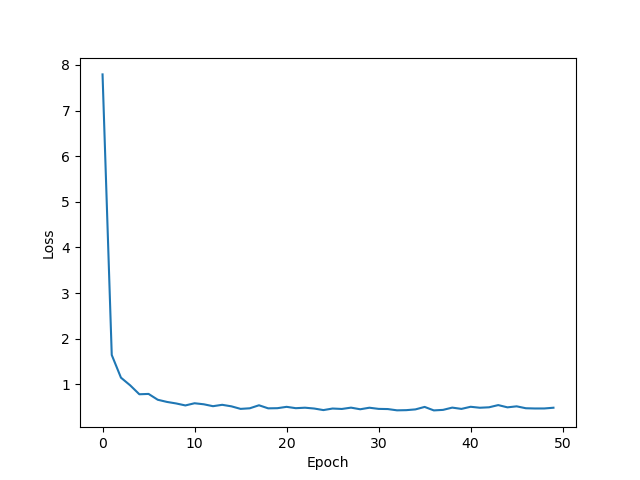

Text(0.5, 0, 'Epoch')

In [120]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

<IPython.core.display.Javascript object>


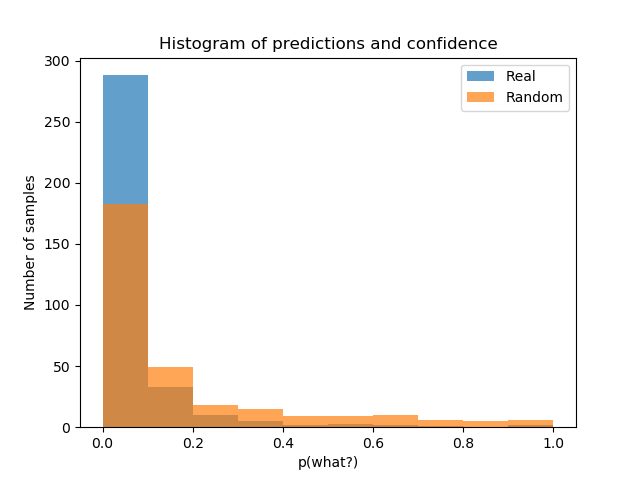

Text(0, 0.5, 'Number of samples')

In [119]:
probs = []
for xi in x:
    pred, logprob, entropy = e([xi])
    probs.append(torch.exp(logprob.detach()).item())

pred_, logprob_, entropy_ = e(np.random.randn(len(x), 13).astype(np.float32))
probs_ = torch.exp(logprob_.detach()).numpy()

bins = np.linspace(0, 1, 11)
plt.hist(probs, bins, alpha=0.7, label='Real')
plt.hist(probs_, bins, alpha=0.7, label='Random')
plt.legend()
plt.title('Histogram of predictions and confidence')
plt.xlabel('p(what?)')
plt.ylabel('Number of samples')